In [1]:
import numpy as np
from tensorflow import keras
from tensorflow import keras
import tensorflow_addons as tfa
import math
import plotly.graph_objs as go

/home/gao/.local/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
def data_process_with_time_windower(volunteer_label, feature_option, time_window_length):
    """
    Processes input and output data from a CSV file, organizing the input data into time-windowed sequences
    and aligning the output data accordingly. This function supports processing for PCA-reduced data or
    raw point cloud data based on the feature option specified.

    Parameters:
    - volunteer_label: A string identifier for the data source (volunteer) being processed.
    - feature_option: A string indicating the type of features to process ('PCA' for PCA-reduced features, any other string assumes raw data with 200 features).
    - time_window_length: An integer specifying the length of the time window for input data sequences.

    Returns:
    - NN_input_package_with_time_windower: A NumPy array containing sequences of input data, each sequence with a length defined by `time_window_length`.
    - NN_output_package_with_time_windower: A NumPy array containing output data aligned with the end of each input sequence.
    """

    # Construct the file name based on the volunteer label and feature option
    file_name = f"{volunteer_label}_{feature_option}.csv"
    
    # Load data from the file
    # If it is the PCA option then the number of features is 7, if it is the raw point cloud then it is 200
    if feature_option == "PCA":
        features_number = 7
    else:
        features_number = 200

    # Load the input data (features) from the CSV file
    NN_input_data = np.loadtxt(file_name, dtype=np.str_, delimiter=",")[0:, :features_number].astype(np.float64)

    # Load the output data (human orientation in the form of (sin,cos) from the CSV file
    NN_output_data = np.loadtxt(file_name, dtype=np.str_, delimiter=",")[0:, features_number:features_number + 2].astype(np.float64)

    # Generate the input data package with a time window
    # This slices the input data into sequences of length 'time_window_length'
    NN_input_package_with_time_windower = np.array([NN_input_data[i:i + time_window_length] for i in range(len(NN_output_data) - time_window_length)])

    # Generate the output data package aligned with the input data windows
    # This takes the output data corresponding to the last element of each input window
    NN_output_package_with_time_windower = np.array([NN_output_data[i + time_window_length - 1] for i in range(len(NN_output_data) - time_window_length)])

    return NN_input_package_with_time_windower, NN_output_package_with_time_windower

def create_block(filters_CNN, kernel_size_CNN, units_RNN, time_window_length, features_number, return_sequences):
    """
    Creates a sequential block of layers including a 1D Convolutional layer, Batch Normalization,
    ReLU activation, and a GRU layer. This block can be used as a part of a larger neural network model,
    especially for processing time series or sequence data.

    Parameters:
    - features_number (int): The number of features in the input data.
    - filters_CNN (int): The number of output filters in the convolution.
    - kernel_size_CNN (int): The length of the 1D convolution window.
    - units_RNN (int): The number of units in the GRU layer.
    - time_window_length (int): The length of the input sequence.
    - return_sequences (bool): Whether to return the last output in the output sequence, or the full sequence.

    Returns:
    - block (list of keras.layers.Layer): A list of layers comprising the block.
    """

    block = [
        # Create a 1D Convolutional layer to learn spatial hierarchies from the input data.
        keras.layers.Conv1D(filters_CNN, kernel_size_CNN, activation='relu', input_shape=(time_window_length, features_number), padding="same"),
        
        # Normalize the activations of the previous layer at each batch, i.e. applies a transformation
        # that maintains the mean activation close to 0 and the activation standard deviation close to 1.
        # Batch Normalization layer is used to accelerate the training and reduce the dependence on training hyperparameter
        keras.layers.BatchNormalization(),
        
        # Apply a rectified linear unit activation function to increase the non-linearity in the model and overcome overfitting,
        # allowing it to learn more complex patterns.
        keras.layers.ReLU(),
        
        # Add a GRU (Gated Recurrent Unit) layer, which is effective for modeling sequential data.
        # It can carry relevant information across many timesteps, especially used for implicit gait estimation.
        keras.layers.GRU(units_RNN, return_sequences=return_sequences),
    ]
    return block

def training(training_input, training_output, validation_set, max_epochs, time_window_length, blocks_number, model_summary, verbose):
    """
    Trains a neural network model with a specified architecture.

    Parameters:
    - training_input: Input data for training the model (features).
    - training_output: Output data for training the model (human orientation).
    - validation_set: A tuple (validation_input, validation_output) used for evaluating the model.
    - max_epochs: Maximum number of epochs to train the model.
    - time_window_length: The length of the time window for input data.
    - blocks_number: Number of blocks (composed of Conv1D and GRU layers) in the model.
    - model_summary: If True, prints a summary of the model architecture.
    - verbose: Verbosity mode.

    Returns:
    - model_DNN: The trained Keras Sequential model.
    - history: Training history object, containing training and validation metrics.
    """

    # Define hyperparameters for the layers
    units_RNN = 25
    filters_CNN = 25
    kernel_size_CNN = 5
    units_Dense = 6

    # Initialize the model architecture
    combine_block = []
    # Create and add the first block
    combine_block.extend(create_block(filters_CNN, kernel_size_CNN, units_RNN, time_window_length, training_input.shape[2], True))
    
    # Add intermediate blocks
    if blocks_number > 2:
        for i in range(blocks_number - 2):
            combine_block.extend(create_block(filters_CNN, kernel_size_CNN, units_RNN, time_window_length, units_RNN, True))
    
    # Add the final block, setting return_sequences=False as it's the last one
    combine_block.extend(create_block(filters_CNN, kernel_size_CNN, units_RNN, time_window_length, units_RNN, False))
    
    # Append Dropout and Dense layers at the end of the model
    combine_block.append(keras.layers.Dropout(0.2))
    combine_block.append(keras.layers.Dense(units_Dense))
    combine_block.append(keras.layers.Dense(2))
    
    # Construct the Sequential model from the combined blocks
    model_DNN = keras.Sequential(combine_block)
    
    # Print the model summary if requested
    if model_summary:
        model_DNN.summary()

    # Setup Early Stopping callback to prevent overfitting
    early_stopping = keras.callbacks.EarlyStopping(
        monitor = "val_mae", # Monitor validation mean absolute error
        patience = 10, # Number of epochs with no improvement after which training will be stopped
        mode = "min",
        restore_best_weights = True, # Restore model weights from the epoch with the best value of the monitored quantity
    )
    
    # Define the batch size and compute steps per epoch taking into account both training and validation data
    batch_size = 64
    steps_per_epoch = round((len(training_input) + len(validation_set[0])) / batch_size)
    
    # Define a cyclical learning rate
    clr = tfa.optimizers.Triangular2CyclicalLearningRate(
        initial_learning_rate = 1.0e-6,
        maximal_learning_rate = 0.01,
        step_size = 2 * steps_per_epoch,
    )
    
    # Compile the model specifying loss function, optimizer, and metrics
    model_DNN.compile(loss="mse", optimizer=keras.optimizers.Adam(clr), metrics="mae")
    
    # Train the model
    history = model_DNN.fit(
        training_input,
        training_output,
        batch_size=batch_size,
        shuffle=True, # Shuffle the training data
        validation_data=validation_set, # Set the validation data
        callbacks=[early_stopping], # Add early stopping to callbacks
        verbose=verbose, # Set verbosity
        epochs=max_epochs # Set the max number of epochs
    )

    # Return the trained model and the training history
    return model_DNN, history
    
def mae_and_std(error_list, index):
    """
    Calculate the mean absolute error (MAE), standard deviation (Std) of the human orientation prediction

    Parameters:
    - error_list: A list or array containing error values (ground truth - predicted).
    - index: An array or list of indices specifying which errors to consider for the calculation.
    """
    errors = np.array(error_list)[index]
    mae = np.mean(np.abs(errors))
    std = np.std(np.abs(errors))
    count = len(index)
    
    print("MAE:", mae, "Std:", std, "Count:", count)
    
    
def data_splitting(volunteer_label, data_set_length):
    """
    Splits the dataset into training, validation, and test sets based on the volunteer label.

    Parameters:
    - volunteer_label: A string identifier for the volunteer, e.g., 'V1', 'V2', etc.
    - data_set_length: The total length of the dataset.

    Returns:
    - training_index: A list of indices for the training set.
    - validation_index: A list of indices for the validation set.
    - test_index: A list of indices for the test set.
    """
    
    if volunteer_label == "V1":
        training_index = np.concatenate([np.arange(26000, 46000), np.arange(0, 21000)]).tolist()
        validation_index = np.arange(21000, 26000).tolist()
        test_index = np.arange(46000, data_set_length).tolist()
        
    if volunteer_label == "V2":
        training_index = np.concatenate([np.arange(0,8000), np.arange(13000,27000), np.arange(32000, data_set_length)]).tolist()
        validation_index = np.arange(8000,13000).tolist()
        test_index = np.arange(27000,32000).tolist()

    if volunteer_label == "V3":
        training_index = np.concatenate([np.arange(0, 5230), np.arange(10230, 30000), np.arange(35000, data_set_length)]).tolist()
        validation_index = np.arange(5230, 10230).tolist()
        test_index = np.arange(30000, 35000).tolist()
        
    if volunteer_label == "V4":
        training_index = np.concatenate([np.arange(0, 13000), np.arange(23000, data_set_length)]).tolist()
        validation_index = np.arange(13000, 18000).tolist()
        test_index = np.arange(18000, 23000).tolist()
        
    if volunteer_label == "V5":
        training_index = np.concatenate([np.arange(0, 6500), np.arange(11500, 39000), np.arange(44000, data_set_length)]).tolist()
        validation_index = np.arange(6500, 11500).tolist()
        test_index = np.arange(39000, 44000).tolist()
        
    return training_index, validation_index, test_index

def general_model(volunteer_labels_training, external_volunteer_label, feature_option, time_window_length, blocks_number, model_summary, verbose, plot):
    """
    Build a general model based on a data set of multiple people and test it on a test set of an untried volunteer

    Parameters:
    - volunteer_labels_training: A string identifier for the volunteers, e.g., '1234', '124', etc.
    - external_volunteer_label: A string identifier for the untried volunteer, e.g., '1', '2', etc.
    - feature_option: A string indicating the type of features to process ('PCA' for PCA-reduced features, any other string assumes raw data with 200 features).
    - time_window_length: The length of the time window for input data.
    - blocks_number: Number of blocks (composed of Conv1D and GRU layers) in the model.
    - model_summary: If True, prints a summary of the model architecture.
    - verbose: Verbosity mode.
    - plot: plot the human orientation ground truth and prediction in test set.
    """
    # Initialize empty lists and variables
    training_index_combine = []
    validation_index_combine = []
    test_index_combine = []
    index_increment = 0
    NN_input_package_with_time_windower_combine = np.array([])
    NN_output_package_with_time_windower_combine = np.array([])
    
    # Process data for each volunteer in the training set
    for i in volunteer_labels_training:
        volunteer_label = f"V{i}"
        NN_input_package_with_time_windower, NN_output_package_with_time_windower = data_process_with_time_windower(volunteer_label,feature_option,time_window_length)
        
        # Concatenate input and output data for each volunteer
        if NN_input_package_with_time_windower_combine.size == 0:
            NN_input_package_with_time_windower_combine = NN_input_package_with_time_windower
            NN_output_package_with_time_windower_combine = NN_output_package_with_time_windower
        else:
            NN_input_package_with_time_windower_combine = np.concatenate((NN_input_package_with_time_windower_combine, NN_input_package_with_time_windower), axis=0)
            NN_output_package_with_time_windower_combine = np.concatenate((NN_output_package_with_time_windower_combine, NN_output_package_with_time_windower), axis=0)
            
        # Split the data
        data_set_length = len(NN_input_package_with_time_windower)
        training_index, validation_index, test_index = data_splitting(volunteer_label, data_set_length)
        
        # Adjust indices and append to the combined indices list
        training_index = [index + index_increment for index in training_index]
        validation_index = [index + index_increment for index in validation_index]
        test_index = [index + index_increment for index in test_index]
        training_index_combine.extend(training_index)
        training_index_combine.extend(test_index)
        validation_index_combine.extend(validation_index)
        index_increment += data_set_length

    # Process data for the external volunteer
    volunteer_label = f"V{external_volunteer_label}"
    NN_input_package_with_time_windower, NN_output_package_with_time_windower = data_process_with_time_windower(volunteer_label,feature_option,time_window_length)
    
    # Concatenate external volunteer data with the combined data
    NN_input_package_with_time_windower_combine = np.concatenate((NN_input_package_with_time_windower_combine, NN_input_package_with_time_windower), axis=0)
    NN_output_package_with_time_windower_combine = np.concatenate((NN_output_package_with_time_windower_combine, NN_output_package_with_time_windower), axis=0)
    
    # Split the external volunteer data into a test set
    data_set_length = len(NN_input_package_with_time_windower)
    training_index, validation_index, test_index = data_splitting(volunteer_label, data_set_length)
    test_index = [index + index_increment for index in test_index]
    test_index_combine.extend(test_index)

    # Extract training, validation, and test datasets
    train_input_data_set = NN_input_package_with_time_windower_combine[training_index_combine]
    train_output_data_set = NN_output_package_with_time_windower_combine[training_index_combine]
    validation_data_set = (
        NN_input_package_with_time_windower_combine[validation_index_combine],
        NN_output_package_with_time_windower_combine[validation_index_combine]
    )

    # Train the model
    trained_model, training_history = training(train_input_data_set, train_output_data_set, validation_data_set, 200, time_window_length, blocks_number, model_summary, verbose)

    # Predict orientations using the trained model
    human_orientation_predict = trained_model.predict(NN_input_package_with_time_windower_combine)

    # Calculate errors between predicted and ground truth orientations
    human_orientation_predict_deg = [math.atan2(pred[0], pred[1]) * 180 / math.pi for pred in human_orientation_predict]
    human_orientation_ground_truth_deg = [math.atan2(gt[0], gt[1]) * 180 / math.pi for gt in NN_output_package_with_time_windower_combine]
    error_predict_deg = [predict - gt for predict, gt in zip(human_orientation_predict_deg, human_orientation_ground_truth_deg)]
    error_predict_deg = [error + 360 if error < -180 else error for error in error_predict_deg]
    error_predict_deg = [360 - error if error > 180 else error for error in error_predict_deg]
    
    if plot == True:
        plot_human_prediction_deg(human_orientation_predict_deg, human_orientation_ground_truth_deg, test_index_combine)

    # Print performance metrics for training, validation, and test sets
    print("DNN performance in training sets:")
    mae_and_std(error_predict_deg,training_index_combine)
    print("DNN performance in validation sets:")
    mae_and_std(error_predict_deg,validation_index_combine)
    print("DNN performance in test sets:")
    mae_and_std(error_predict_deg,test_index_combine)
    
    
def customized_model(volunteer_label, feature_option, time_window_length, blocks_number, model_summary, verbose, plot):
    """
    Build customized models based on individual data and test them on their own test sets
    
    Parameters:
    - volunteer_label: A string identifier for the volunteer, e.g., 'V1', 'V2', etc.
    - feature_option: A string indicating the type of features to process ('PCA' for PCA-reduced features, any other string assumes raw data with 200 features).
    - time_window_length: The length of the time window for input data.
    - blocks_number: Number of blocks (composed of Conv1D and GRU layers) in the model.
    - model_summary: If True, prints a summary of the model architecture.
    - verbose: Verbosity mode.
    - plot: plot the human orientation ground truth and prediction in test set.
    """

    # Process data with time windowing
    NN_input_package_with_time_windower, NN_output_package_with_time_windower = data_process_with_time_windower(volunteer_label,feature_option,time_window_length)
    data_set_length = len(NN_input_package_with_time_windower)
    
    # Split data into training, validation, and test sets
    training_index, validation_index, test_index = data_splitting(volunteer_label, data_set_length)

    # Extract training, validation, and test datasets
    train_input_data_set = NN_input_package_with_time_windower[training_index]
    train_output_data_set = NN_output_package_with_time_windower[training_index]
    validation_data_set = (
        NN_input_package_with_time_windower[validation_index],
        NN_output_package_with_time_windower[validation_index]
    )
    
    # Train the model and get the trained model and training history
    trained_model, training_history = training(train_input_data_set, train_output_data_set, validation_data_set, 100, time_window_length, blocks_number, model_summary, verbose)

    # Predict orientations using the trained model
    human_orientation_predict = trained_model.predict(NN_input_package_with_time_windower)

    # Calculate predicted orientations and ground truth orientations (in degrees)
    human_orientation_predict_deg = [math.atan2(pred[0], pred[1]) * 180 / math.pi for pred in human_orientation_predict]
    human_orientation_ground_truth_deg = [math.atan2(gt[0], gt[1]) * 180 / math.pi for gt in NN_output_package_with_time_windower]

    # Calculate errors between predicted and ground truth orientations
    error_predict_deg = [predict - gt for predict, gt in zip(human_orientation_predict_deg, human_orientation_ground_truth_deg)]
    error_predict_deg = [error + 360 if error < -180 else error for error in error_predict_deg]
    error_predict_deg = [360 - error if error > 180 else error for error in error_predict_deg]

    if plot == True:
        plot_human_prediction_deg(human_orientation_predict_deg, human_orientation_ground_truth_deg, test_index)

    # Print performance metrics for training, validation, and test sets
    print("DNN performance in training sets:")
    mae_and_std(error_predict_deg,training_index)
    print("DNN performance in validation sets:")
    mae_and_std(error_predict_deg,validation_index)
    print("DNN performance in test sets:")
    mae_and_std(error_predict_deg,test_index)

def plot_human_prediction_deg(human_orientation_predict_deg, human_orientation_ground_truth_deg, plot_index):
    trace0 = go.Scatter(
        x = np.linspace(0, len(plot_index)/10,len(plot_index)),
        y=np.array(human_orientation_ground_truth_deg)[plot_index], 
        mode="lines",  
        name="Ground truth",
        marker={
            "size": 5,
            "color": "rgba(255, 12, 111, 0.7)",
        })

    trace1 = go.Scatter(
        x = np.linspace(0, len(plot_index)/10,len(plot_index)),
        y=np.array(human_orientation_predict_deg)[plot_index],
        mode="lines",  
        name="Neural Network",
        marker={
            "size": 5,
            "color": "rgba(12, 255, 111, 0.7)",
        }
    )

    fig = go.Figure(data=[trace0, trace1],
                    layout={"title": {"text": "Performance of Neural Networks Estimating Human Orientation in the Test Set", "font": {"family": "STKaiti", "size": 30}, "x": 0.5},
                            "xaxis": {"title": "time (s)",
                                      "titlefont": {"family": "STKaiti", "size": 15},
                                      "tickangle": -60, "nticks": 20},
                            "yaxis": {"title": "Human relative orientation (°)",
                                      "titlefont": {"family": "STKaiti", "size": 15}},
                            "font": {"size": 20},
                            })
    fig.update_layout(
        autosize=False,
        width=1400,
        height=800,)

    fig.show()

8283/8283 [==============================] - 20s 2ms/step


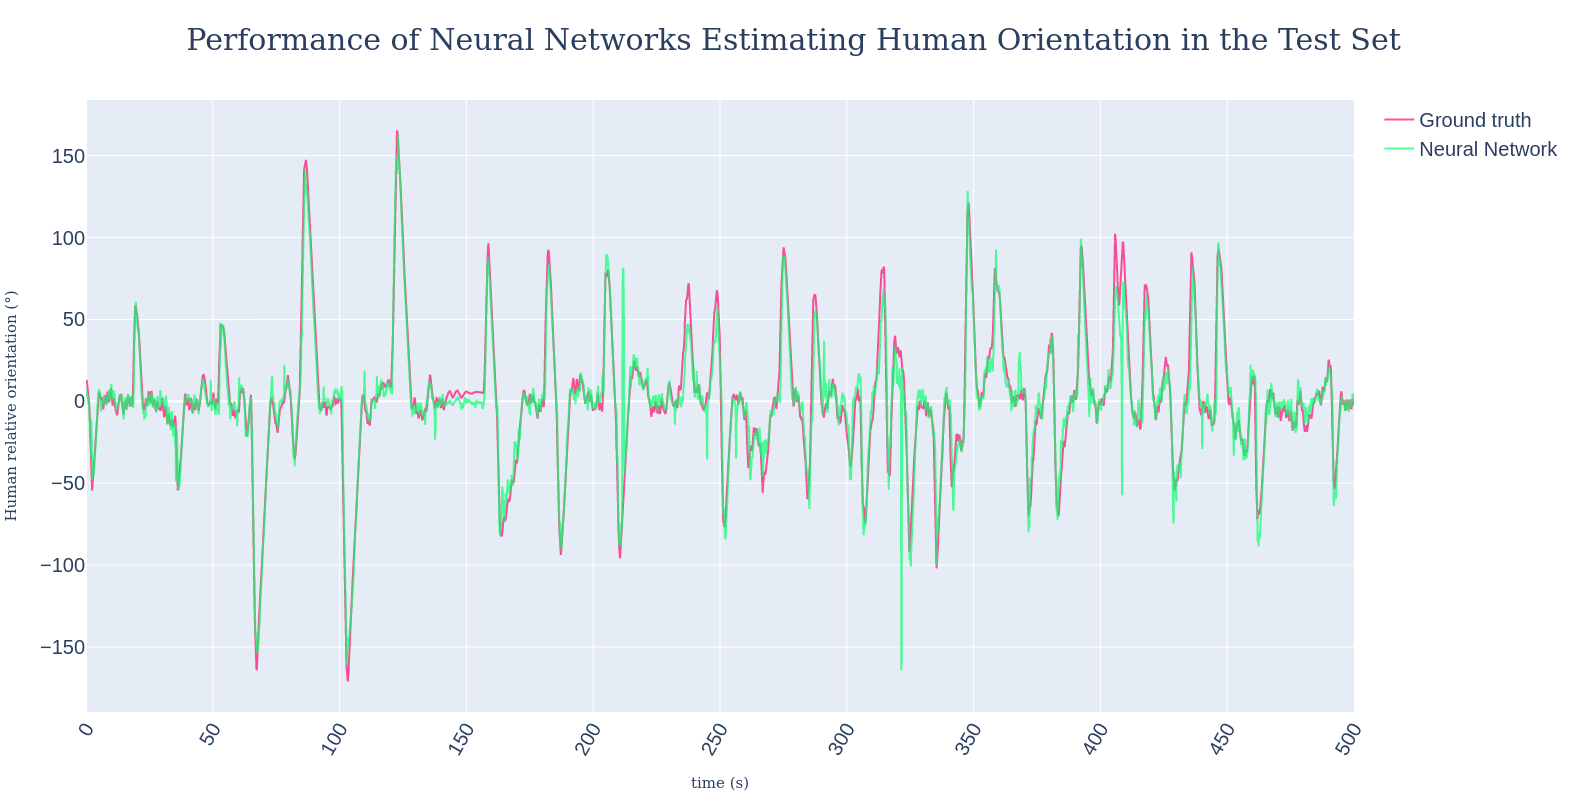

DNN performance in training sets:
MAE: 4.740241153130017 Std: 4.8323956290962435 Count: 198073
DNN performance in validation sets:
MAE: 6.725714144321892 Std: 12.514038799569288 Count: 20000
DNN performance in test sets:
MAE: 6.7172569305633605 Std: 9.939493888289073 Count: 5000


In [7]:
general_model("1234", "5", "PCA", 50, 4, False, 0, True)

1597/1597 [==============================] - 3s 2ms/step


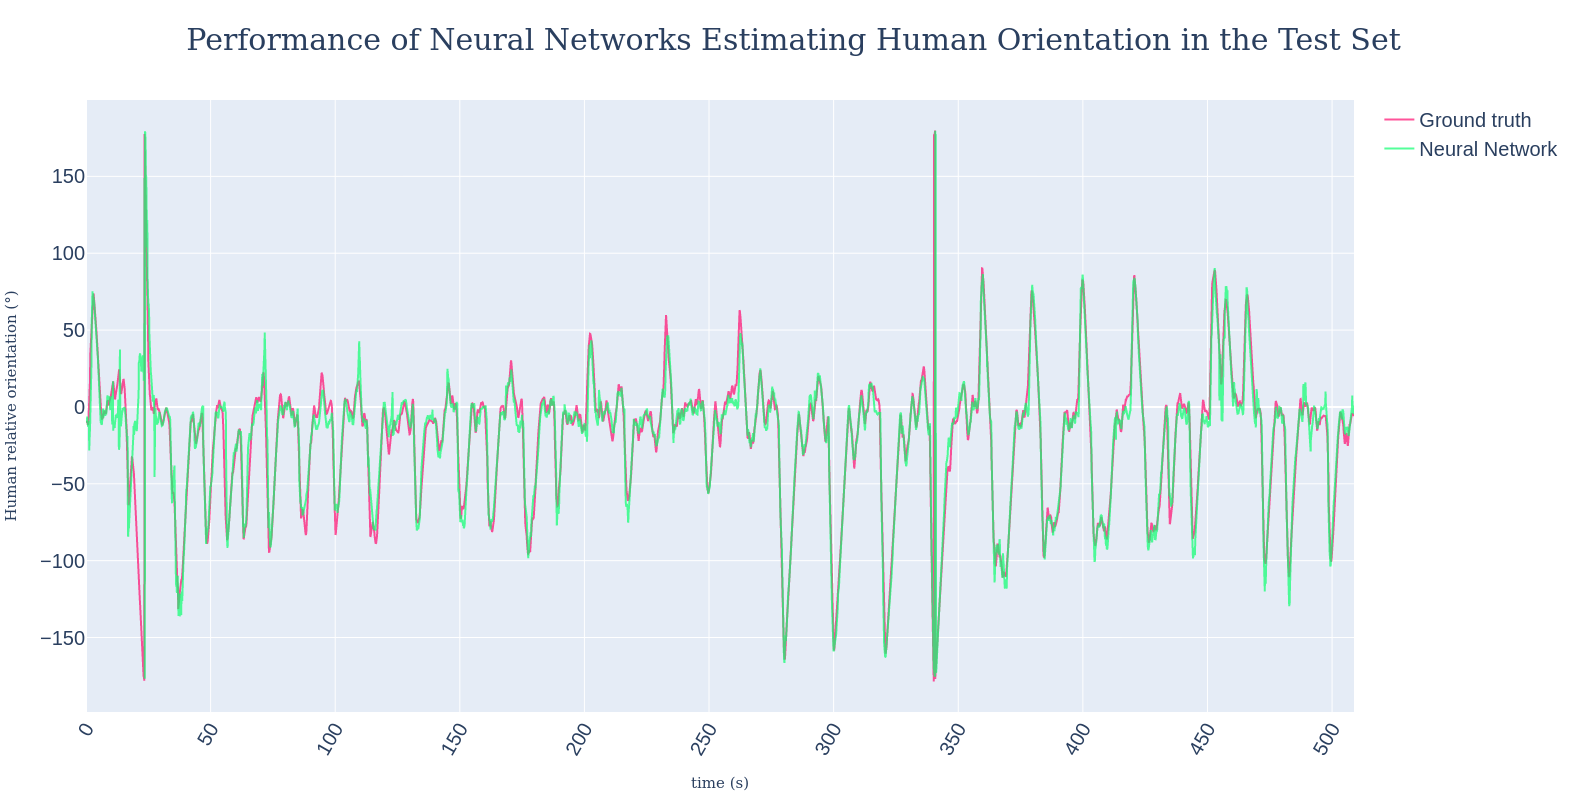

DNN performance in training sets:
MAE: 3.767525978044687 Std: 3.4563132289922804 Count: 41000
DNN performance in validation sets:
MAE: 4.935391946582933 Std: 6.469391142322909 Count: 5000
DNN performance in test sets:
MAE: 6.740441828371863 Std: 12.984879249899137 Count: 5088


In [6]:
customized_model("V1", "PCA", 40, 3, False, 0, True)